In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import folium
import plotly_express as px
import os
import warnings
import json
from datetime import datetime, date
import os
import shapefile
from shapely.geometry import box
from datetime import datetime as dt
import pyproj
import rasterio
from rasterio.mask import mask
from shapely.ops import transform
from rasterio.io import MemoryFile
import earthpy.plot as ep
from folium import Map, GeoJson, Figure
import rioxarray as rxr
import rasterio as rio
import yaml
# open shape files for Cameroon
import geopandas as gpd

from labels import *
import os
from rio_tiler.io import STACReader


In [2]:
#Set the path to data
aoi_dir = "/Users/noeliaotero/Documents/douala-chapter-automatic-land-use/src/data/aoi"
aoi_file = "littoral_outline.geojson"
aoi_path = os.path.join(aoi_dir , aoi_file )

In [5]:
def get_bounds_of_AoI(obj_aoi, offset):
    
    aoi = gpd.read_file(obj_aoi)
    
    bounds = aoi.total_bounds
    #offset = 1/60  #200m in degree
    # Extend the bounding box by 200 m
    minx, miny = bounds[0]-offset, bounds[1]-offset
    maxx, maxy = bounds[2]+offset, bounds[3]+offset

    bbox = box(minx, miny, maxx, maxy)
    
    print(bbox)

    geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs="EPSG:4326")

    
    return  geo 

In [7]:
bbx = get_bounds_of_AoI(aoi_path, 1/60)


POLYGON ((11.094414006666668 3.243667343333333, 11.094414006666668 5.351516026666666, 9.319134458233293 5.351516026666666, 9.319134458233293 3.243667343333333, 11.094414006666668 3.243667343333333))


In [8]:
values = []
for i in range(len(bbx.total_bounds)):
    values.append(bbx.total_bounds[i])
keys = ["lonmin", "latmin", "lonmax", "latmax"]  
geometry = dict(zip(keys, values))

In [10]:
print(values)

[9.319134458233293, 3.243667343333333, 11.094414006666668, 5.351516026666666]


In [ ]:
#We can also set the AOI using the shapefile of Cameroon

In [18]:
gdf = gpd.read_file('/Users/noeliaotero/Documents/Geo_analysis/cameroon.json')
# Set the crs to EPSG 4326 in case of our data is in aonther crs
gdf  = gdf.to_crs("EPSG:4326")
# Get AOI bounds
bbox_aoi = gdf.geometry.total_bounds
# Get AOI centroid for plotting with folium
centroid_aoi = [box(*bbox_aoi).centroid.x, box(*bbox_aoi).centroid.y]
print(bbox_aoi)

[12.17747531  5.02154296 12.17747531  5.02154296]


In [12]:
from pystac_client import Client


stac_endopoint = 'https://services.terrascope.be/stac/'

# collection ids for both maps in the Terrascope STAC Catalogue
collection_ids = {2020: 'urn:eop:VITO:ESA_WorldCover_10m_2020_AWS_V1',
                  2021: 'urn:eop:VITO:ESA_WorldCover_10m_2021_AWS_V2'}

# WSG84 coordinates of Doula
# Use the bbx defined above

client = Client.open(stac_endopoint)

# Let's query products for the 2021 map 
year = 2021
search_results = client.search(
    collections=[collection_ids[year]],
    bbox=list(values)
)

# Search results fetched and represented as dictionary
results = search_results.get_all_items()
# results.to_dict()

In [13]:
# there is only 1 tile
item = results[0]

# retrieve the s3 path from the item
s3uri = item.assets['ESA_WORLDCOVER_10M_MAP'].href
s3uri

's3://esa-worldcover/v200/2021/map/ESA_WorldCover_10m_2021_v200_N03E009_Map.tif'

In [15]:

# this is to tell GDAL we do not need authentication
os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'

# name of the map asset
asset = 'ESA_WORLDCOVER_10M_MAP'

with STACReader(None, item=item) as stac:
    img = stac.part(values, assets=asset)

In [19]:
print(img.data.shape)

(1, 25294, 21303)


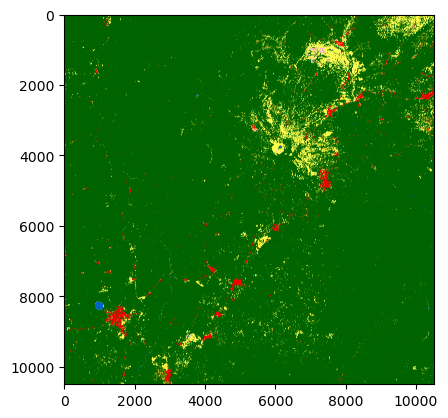

In [23]:
# Note that I am plotting a smaller area (it takes time)
rgb_data = label_to_rgb(img.data[0][0:10500,0:10500])
fig, ax = plt.subplots()
ax.imshow(rgb_data)

/var/folders/3p/7044wnn96f970j23ks8v97240000gn/T/ipykernel_37122/3092487147.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


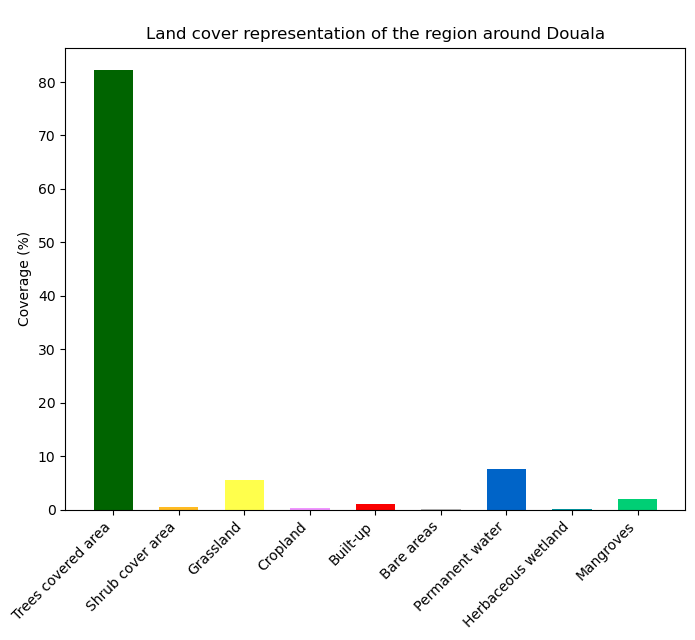

In [24]:
values, occurences = np.unique(img.data[0], return_counts=True)


occurences = occurences / occurences.sum() * 100
label_names = [legend_dict[val] for val in values]
values_colors = label_to_rgb(values.reshape(-1, 1)).squeeze()


fix, ax = plt.subplots(figsize=(8, 6))
ax.bar(x=label_names[1:], height=occurences[1:], color=values_colors[1:], width=0.6)
ax.set_title('\nLand cover representation of the region around Douala')
ax.set
ax.set_ylabel('Coverage (%)')
plt.xticks(rotation=45, ha='right')
fig.show()